In [1]:
#Leser inn moduler
import pandas as pd
import datetime
import re
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import xroms
import pyresample


## Lese inn filer for Mooring M og South Cape:

In [2]:
# Filer for Mooring M:
# Lese inn netcdf filen til deployment 1:

df_d1 = "/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment1/StationM_2021_hydrography.nc"

# Lese inn tekstfilene for deployment 2 (d2) ved 500, 800, 1000, 1200 m:

txtfile_d2_500m  = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment2/StaM_SBE_20211127_500m.txt'
txtfile_d2_800m  = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment2/StaM_SBE_20211127_800m.txt'
txtfile_d2_1000m = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment2/StaM_SBE_20211127_1000m.txt'
txtfile_d2_1200m = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment2/StaM_SBE_20211127_1200m.txt'
txtfile_d2_2000m = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment2/StaM_SBE_20211127_2000m.txt'

# Lese inn tekstfilene for deployment 3 (d3) ved 500, 800, 1000, 1200 m:

txtfile_d3_500m  = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment3/StaM_SBE_20221125_500m.txt'
txtfile_d3_800m  = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment3/StaM_SBE_20221125_800m.txt'
txtfile_d3_1000m = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment3/StaM_SBE_20221125_1000m.txt'
txtfile_d3_1200m = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment3/StaM_SBE_20221125_1200m.txt'
txtfile_d3_2000m = '/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/StationM/Deployment3/StaM_SBE_20221125_2000m.txt'

# Lese inn filer for Mooring South Cape:

south_cape_df = "/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/SouthCape/T_S_SouthCape.csv"


### Lager en funksjon som tar ut dybdeverdien basert på tittelen til txt filen

In [3]:

def get_depth(filename):
    # Use a regular expression to extract the depth value
    depth_match = re.search(r'_(\d+)m', filename)
    if depth_match:
        depth_value = int(depth_match.group(1))
    else:
        depth_value = None
    return(depth_value)  

In [4]:
def txt_to_pd(txtfile, lat, lon):

    columns_to_keep = ['T_degC', 'T_qf', 'S', 'S_qf', 'Date', 'Time']
    new_column_names = ['TEMP','TEMP_QC','PSAL','PSAL_QC','Date','Time']


    # Hvis vi vil at pandas skal tolke dato som som et datetime object
    # kan vi gi informasjon om hvordan dato stirngene er formatert med parser.  
    #
    # For denne filen vil det kunne se slik ut:
    # parse = lambda x: datetime.datetime.strptime(x, '%d %b %Y %H:%M:%S')
    # Betydningen av de ulike %bokstaven finnes her: (https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

    # Men for å gjøre ting litt vanskligere er det brukt norske forkortelser for månedsnavn...
    # Vi bytter enkelt ut norske forkortelser med engelske ved å bruke metoden .replace(norsk, engelsk)

    parse = lambda x: datetime.datetime.strptime(x.replace('Des', 'Dec').replace('Mai', 'May').replace('Okt', 'Oct'), '%d %b %Y %H:%M:%S')

    #df = pd.read_csv(txtfile, delimiter='\t', usecols=columns_to_keep, parse_dates={"Datetime" : ['Date', 'Time']}, date_parser = parse)
    df = pd.read_csv(txtfile, delimiter='\t', usecols=columns_to_keep)
    df.columns = new_column_names
   
    # Combine Date and Time columns and strip any leading or trailing whitespace
    df['TIME'] = (df['Date'] + ' ' + df['Time']).str.strip()
   
    # Apply the custom parsing function
    df['TIME'] = df['TIME'].apply(parse)
    df.drop(columns=['Date', 'Time'], inplace=True)
   
    # Add depth:
    df['DEPTH'] = get_depth(txtfile)
    df['LATITUDE'] = lat
    df['LONGITUDE'] = lon
    
    # Add a column for the quality controlled salinity data:
    df["PSAL_FILTER"] = np.where((df["PSAL_QC"] > 0) & (df["PSAL_QC"] < 3), df["PSAL"], np.nan)

    # Add a column for the quality controlled temperature data:
    df["TEMP_FILTER"] = np.where((df["TEMP_QC"] > 0) & (df["TEMP_QC"] < 3), df["TEMP"], np.nan)
        
    return(df)

In [5]:
def netcdf_to_pd(txt):
    # Load the NetCDF file using xarray
    ds = xr.open_dataset(txt)

    # Select the variables you are interested in
    variables = ['TEMP', 'TEMP_QC', 'PSAL', 'PSAL_QC']

    # Initialize an empty DataFrame to merge into
    df_combined = pd.DataFrame()

    # Loop over each variable to process and merge
    for var in variables:

        # Select the variable data
        data = ds[var]
   
        # Stack the depth and time dimensions into a MultiIndex
        stacked_data = data.stack(points=('DEPTH', 'TIME'))
   
        # Convert the stacked DataArray to a pandas DataFrame
        df = stacked_data.to_dataframe()
           
        # Temporarily rename columns to avoid conflicts
        df.rename(columns={'DEPTH': 'Depth_col', 'TIME': 'Time_col'}, inplace=True)
        #        
        df = df.reset_index()
        df.drop(columns=['Depth_col', 'Time_col'], inplace=True)
        #    
        # If df_combined is empty, initialize it with the current DataFrame
        if df_combined.empty:
            df_combined = df
        else:
            # Merge the current DataFrame with the combined DataFrame
            df_combined = pd.merge(df_combined, df, on=['DEPTH', 'TIME'], how='outer')
    
    # Add latitude and longitude column to the combined dataframe
    df_combined["LATITUDE"] = ds["LATITUDE"].values[0]
    df_combined['LONGITUDE'] = ds['LONGITUDE'].values[0] 
    
    # Make a column for temp and sal values are of good quality
    df_combined["PSAL_FILTER"] = np.where((df_combined["PSAL_QC"] > 0) & (df_combined["PSAL_QC"] < 3), df_combined["PSAL"], np.nan)
    df_combined["TEMP_FILTER"] = np.where((df_combined["TEMP_QC"] > 0) & (df_combined["TEMP_QC"] < 3), df_combined["TEMP"], np.nan)
        
    return(df_combined)        


In [6]:
def csv_to_pd(csvfile, lat, lon, start_date, end_date):
    names = ['timestamp', 'ensemble', 'ErrorFlags', 'Temperature', 'Pressure', 'Salinity']

    parse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

    df = pd.read_csv(csvfile, names=names, header=1, usecols=[1, 2, 3, 4, 5, 6], infer_datetime_format=True, parse_dates=["timestamp"], date_parser=parse)

    df['DEPTH'] = np.abs(gsw.z_from_p(df['Pressure'], lat))
    df['LATITUDE'] = lat
    df['LONGITUDE'] = lon
    
    df = df[df['timestamp'] <= end_date]
    df = df[df['timestamp'] >= start_date]
    
    df.rename(columns={'timestamp': 'TIME', 'Temperature': 'TEMP', 'Salinity': 'PSAL'}, inplace=True)
    
    df['TIME'] = pd.to_datetime(df['TIME'])
    return df

In [7]:
# Funksjon som resampler dataen fra datafilen for å bergne gjennomsnitt, minimum, maksimum og en tilfeldig måling per time.
def resample_data(df):
    
    # Sjekk om 'TIME' kolonnen eksisterer
    if 'TIME' not in df.columns:
        raise ValueError("DataFrame does not have a 'TIME' column.")

    df_copy = df.copy()
    
    # Sett 'TIME' som indeks for å resample dataen
    df_copy.set_index('TIME', inplace=True)

    # Resample dataen for å beregne gjennomsnitt, minimum, maksimum og en tilfeldig måling per time
    df_resampled = df_copy.resample('H').agg({
        'TEMP': ['mean', 'min', 'max', 'first'],
        'PSAL': ['mean', 'min', 'max', 'first']
    })

    # Flatten multi-level columns
    df_resampled.columns = ['_'.join(col).strip() for col in df_resampled.columns.values]
    df_resampled.reset_index(inplace=True)

    return df_resampled

In [8]:
# Gjør om alle mooring observasjonene til pandas dataframes
d1 = netcdf_to_pd(df_d1)
d2_500m  = txt_to_pd(txtfile_d2_500m,  65.015, 1.983)
d2_800m  = txt_to_pd(txtfile_d2_800m,  65.015, 1.983)
d2_1000m = txt_to_pd(txtfile_d2_1000m, 65.015, 1.983)
d2_1200m = txt_to_pd(txtfile_d2_1200m, 65.015, 1.983)
d2_2000m = txt_to_pd(txtfile_d2_2000m, 65.015, 1.983)

d3_500m  = txt_to_pd(txtfile_d3_500m,  66.0, 1.99)
d3_800m  = txt_to_pd(txtfile_d3_800m,  66.0, 1.99)
d3_1000m = txt_to_pd(txtfile_d3_1000m, 66.0, 1.99)
d3_1200m = txt_to_pd(txtfile_d3_1200m, 66.0, 1.99)
d3_2000m = txt_to_pd(txtfile_d3_2000m, 66.0, 1.99)

south_cape = csv_to_pd(south_cape_df, 76.107, 15.967, "2022-04-14","2023-04-20")
south_cape_resampled = resample_data(south_cape)

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in z_from_p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
d1_500m  = d1[d1['DEPTH']==500]
d1_800m  = d1[d1['DEPTH']==800]
d1_1000m = d1[d1['DEPTH']==1000]
d1_1200m = d1[d1['DEPTH']==1200]
d1_2000m = d1[d1['DEPTH']==2000]

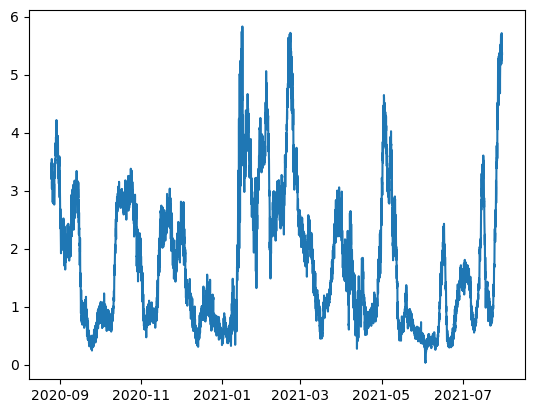

In [37]:
plt.plot(d1_500m["TIME"], d1_500m["TEMP"])

In [48]:
snap = d1_500m["TIME"][0:875]
snap_temp = d1_500m["TEMP"][0:875]

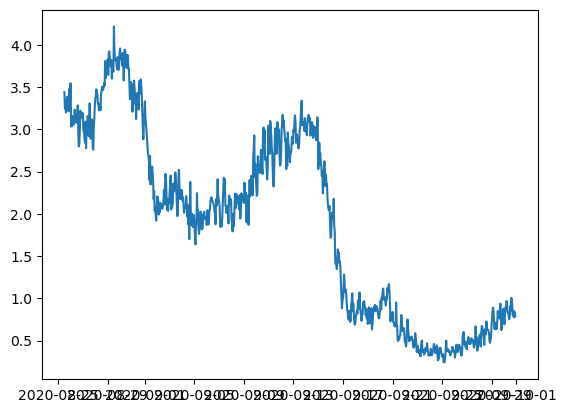

In [49]:
plt.plot(snap, snap_temp)

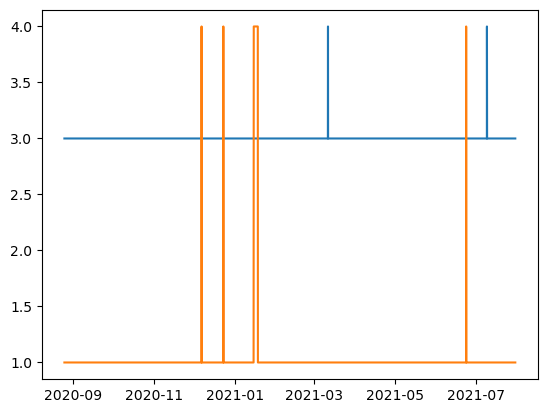

In [11]:
plt.plot(d1_2000m["TIME"], d1_2000m["PSAL_QC"])
plt.plot(d1_1200m["TIME"], d1_1200m["PSAL_QC"])

In [12]:
frames = [d1, d2_500m, d2_800m, d2_1000m, d2_1200m, d2_2000m, d3_500m, d3_800m, d3_1000m, d3_1200m, d3_2000m]

In [13]:
frames_500 = [d1_500m, d2_500m, d3_500m]
frames_800 = [d1_800m, d2_800m, d3_800m]
frames_1000 = [d1_1000m, d2_1000m, d3_1000m]
frames_1200 = [d1_1200m, d2_1200m, d3_1200m]
frames_2000 = [d1_2000m, d2_2000m, d3_2000m]


In [14]:
all_500 = pd.concat(frames_500,ignore_index=True)
all_800 = pd.concat(frames_800,ignore_index=True)
all_1000 = pd.concat(frames_1000,ignore_index=True)
all_1200 = pd.concat(frames_1200,ignore_index=True)
all_2000 = pd.concat(frames_2000,ignore_index=True)


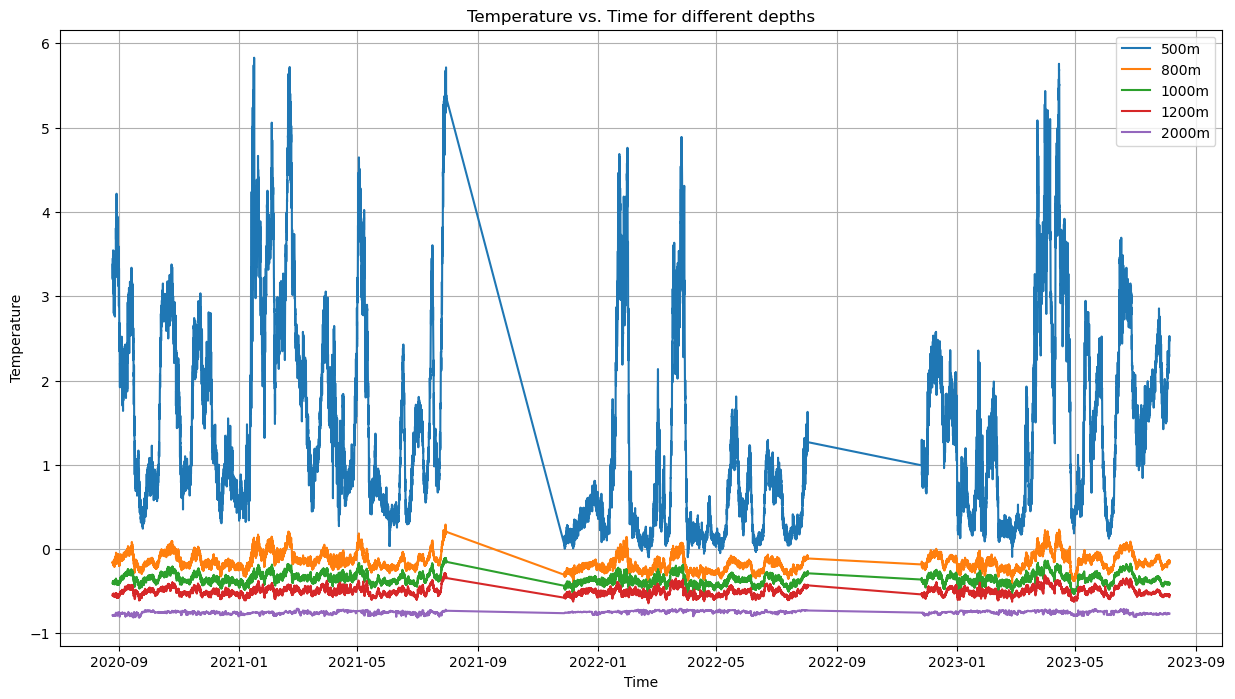

In [15]:
plt.figure(figsize=(15,8))
plt.plot(all_500["TIME"], all_500["TEMP"], label="500m")
plt.plot(all_800["TIME"], all_800["TEMP"], label="800m")
plt.plot(all_1000["TIME"], all_1000["TEMP"], label="1000m")
plt.plot(all_1200["TIME"], all_1200["TEMP"], label="1200m")
plt.plot(all_2000["TIME"], all_2000["TEMP"], label="2000m")
plt.legend()
plt.title("Temperature vs. Time for different depths")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid()

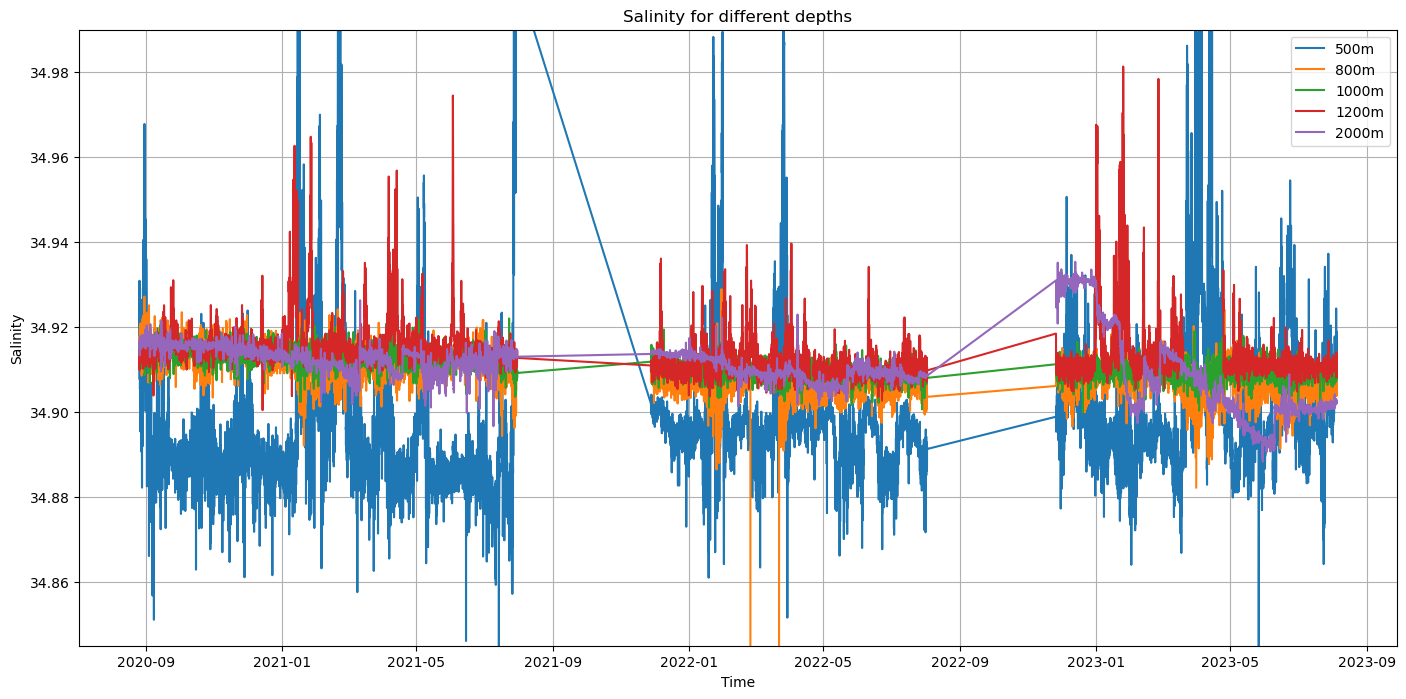

In [16]:
plt.figure(figsize=(17,8))
plt.plot(all_500["TIME"], all_500["PSAL_FILTER"], label="500m")
plt.plot(all_800["TIME"], all_800["PSAL_FILTER"], label="800m")
plt.plot(all_1000["TIME"], all_1000["PSAL_FILTER"], label="1000m")
plt.plot(all_1200["TIME"], all_1200["PSAL_FILTER"], label="1200m")
plt.plot(all_2000["TIME"], all_2000["PSAL"], label="2000m")
plt.legend()
plt.title("Salinity for different depths")
plt.xlabel("Time")
plt.ylim([34.845, 34.99])
plt.ylabel("Salinity")
plt.grid()

In [17]:
all_1000["TIME"]

0       2020-08-25 12:00:00.000000000
1       2020-08-25 12:59:03.750000128
2       2020-08-25 14:00:56.249999872
3       2020-08-25 15:00:00.000000000
4       2020-08-25 15:59:03.750000128
                     ...             
20123   2023-08-04 08:00:04.000000000
20124   2023-08-04 09:00:04.000000000
20125   2023-08-04 10:00:04.000000000
20126   2023-08-04 11:00:04.000000000
20127   2023-08-04 12:00:04.000000000
Name: TIME, Length: 20128, dtype: datetime64[ns]

Text(0.5, 0.98, 'Temperature and Salinity in South Cape')

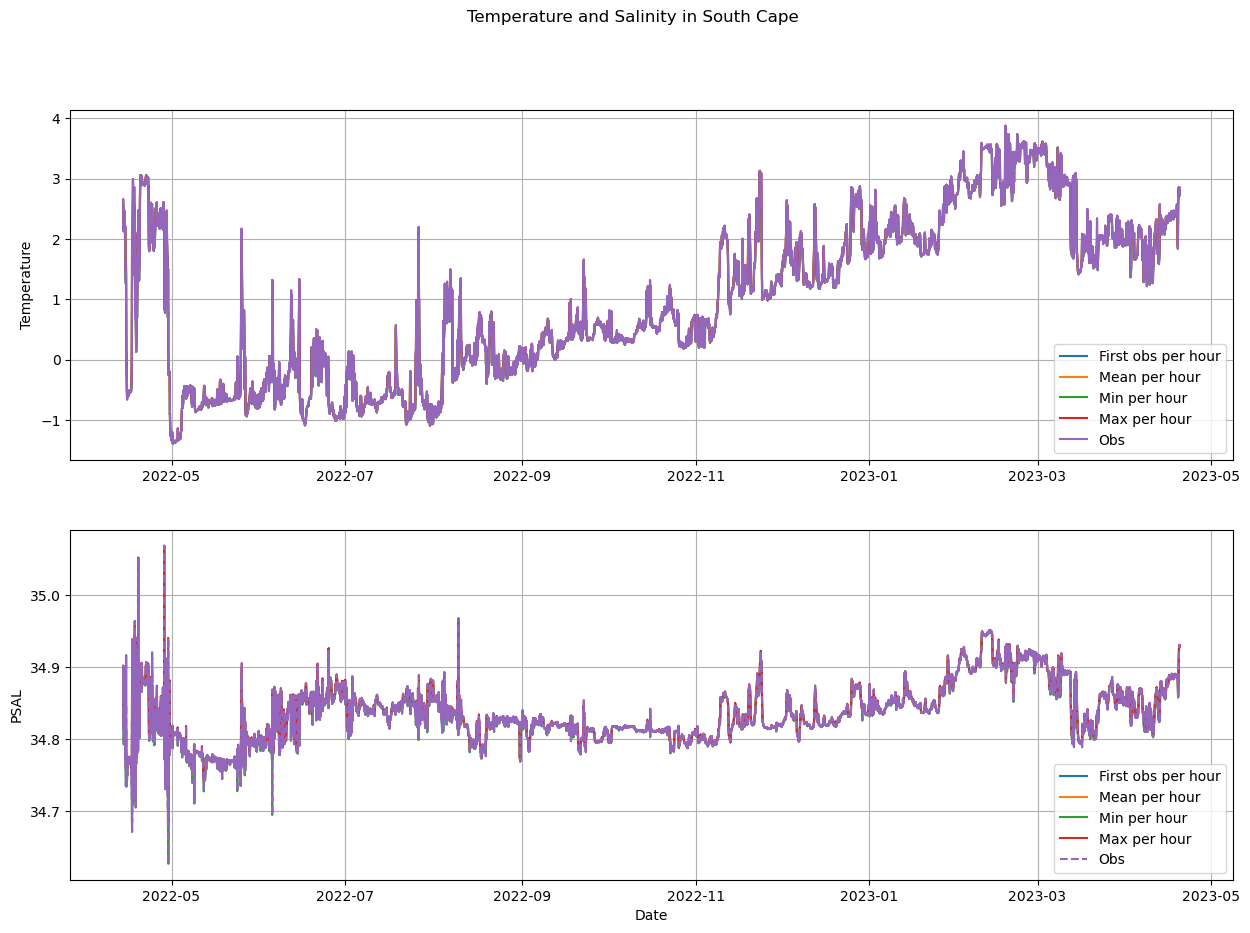

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot TEMP-data på øverste subplot
ax1.plot(south_cape_resampled['TIME'], south_cape_resampled["TEMP_first"], label="First obs per hour")
ax1.plot(south_cape_resampled['TIME'], south_cape_resampled["TEMP_mean"], label="Mean per hour")
ax1.plot(south_cape_resampled['TIME'], south_cape_resampled["TEMP_min"], label="Min per hour")
ax1.plot(south_cape_resampled['TIME'], south_cape_resampled["TEMP_max"], label="Max per hour")
ax1.plot(south_cape['TIME'], south_cape['TEMP'], label="Obs", linestyle = "-")
ax1.set_ylabel('Temperature')
ax1.legend()
ax1.grid()

# Plot PSAL-data på nederste subplot
ax2.plot(south_cape_resampled['TIME'], south_cape_resampled["PSAL_first"], label="First obs per hour")
ax2.plot(south_cape_resampled['TIME'], south_cape_resampled["PSAL_mean"], label="Mean per hour")
ax2.plot(south_cape_resampled['TIME'], south_cape_resampled["PSAL_min"], label="Min per hour")
ax2.plot(south_cape_resampled['TIME'], south_cape_resampled["PSAL_max"], label="Max per hour")
ax2.plot(south_cape['TIME'], south_cape['PSAL'], label="Obs", linestyle = "--")
ax2.set_xlabel('Date')
ax2.set_ylabel('PSAL')
ax2.legend()
ax2.grid()

# Sett tittelen for hele plottet
fig.suptitle('Temperature and Salinity in South Cape')


In [19]:
framesd2 = pd.concat([d2_500m, d2_800m, d2_1000m, d2_1200m, d2_2000m])

In [20]:
def plot_stationM():

    proj = ccrs.Orthographic(0,45)
    ocean  = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
    land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
        edgecolor='k',
        facecolor=cfeature.COLORS['land'])

    fig, ax = plt.subplots(figsize=(7,7),subplot_kw=dict(projection=proj), ncols=1, nrows = 1)

    # Sett grenser for kartutsnittet  - her fra -30E til 30E, og fra 50N til 90N.
    ax.set_extent([-30, 30, 50, 90], ccrs.PlateCarree())

    # Plott land (farger og kantlinje er satt i variabelen land_10m over)
    ax.add_feature(land_10m, facecolor='burlywood', alpha=0.74 )

    # Legg på landegrenser
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
    ax.gridlines(zorder=100, draw_labels=True)

    # Plott posisjonen til Stasjon M
    # X = lon ,  Y = lat, transform = ccrs.PlateCarree forteller cartopy at X og Y er lengde- og breddegrad. 
    ax.scatter([d1["LONGITUDE"][0]], [d1["LATITUDE"][0]], marker = '*', transform = ccrs.PlateCarree(), label = 'Station M D1', color = 'red')
    ax.scatter([d2_800m["LONGITUDE"][0]], [d2_800m["LATITUDE"][0]],marker = '*', transform = ccrs.PlateCarree(), label = 'Station M D2', color = 'blue')
    ax.scatter([d3_800m["LONGITUDE"][0]], [d3_800m["LATITUDE"][0]], marker = '*', transform = ccrs.PlateCarree(), label = 'Station M D3', color = 'mediumslateblue')
    ax.scatter([south_cape["LONGITUDE"][197]], [south_cape["LATITUDE"][197]], marker = '*', transform = ccrs.PlateCarree(), label = 'Station M D3', color = 'coral')
    
    ax.legend()
    
    return fig, ax


Valgt dato: 12.06.24


/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


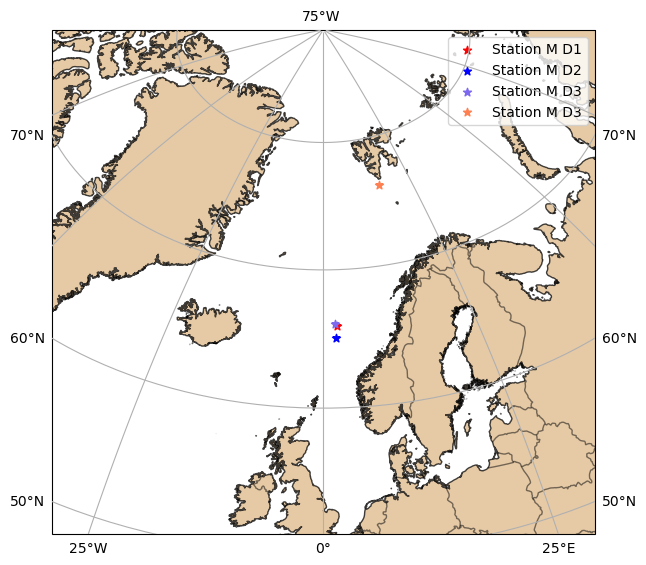

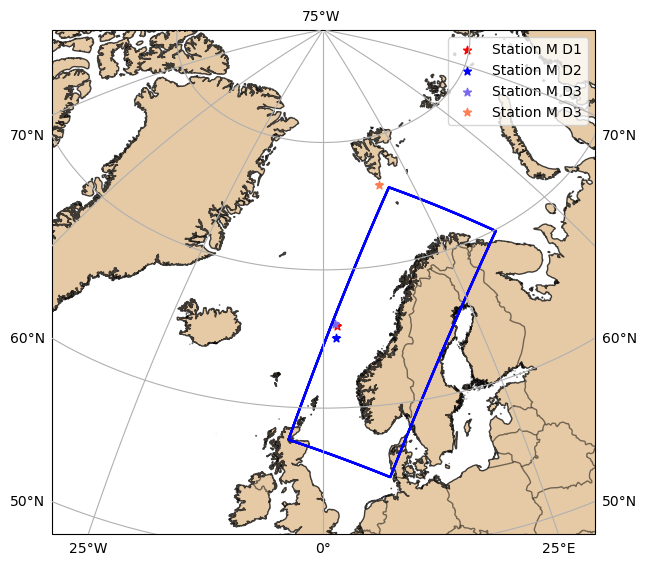

In [21]:
fig, ax = plot_stationM()
my_date = datetime.datetime(2024, 6, 12)
print('Valgt dato: {}'.format(my_date.strftime('%d.%m.%y')))
norkyst_DA_template = 'https://thredds.met.no/thredds/dodsC/sea_norshelf_files/{}/norshelf_qck_an_{}T00Z.nc'

# åpne filen for valgt dato (samme som i cellen over). 
# Merk at det er to sett med klammer i template, så dermed trenger vi to argumenter i format
norkystDA_ds = xr.open_dataset(norkyst_DA_template.format(my_date.strftime('%Y/%m') , my_date.strftime('%Y%m%d')))
# Lag en "ramme" som viser området modellen dekker:
norkystDA_domain = np.ones_like(norkystDA_ds.lon_rho.values); norkystDA_domain[1:-1, 1:-1] = 0

# Plott område sammen med Stasjon M:
fig, ax = plot_stationM()
cs = ax.contour(norkystDA_ds.lon_rho.values, norkystDA_ds.lat_rho.values, norkystDA_domain, colors = 'b', linewidth = 3, transform = ccrs.PlateCarree())


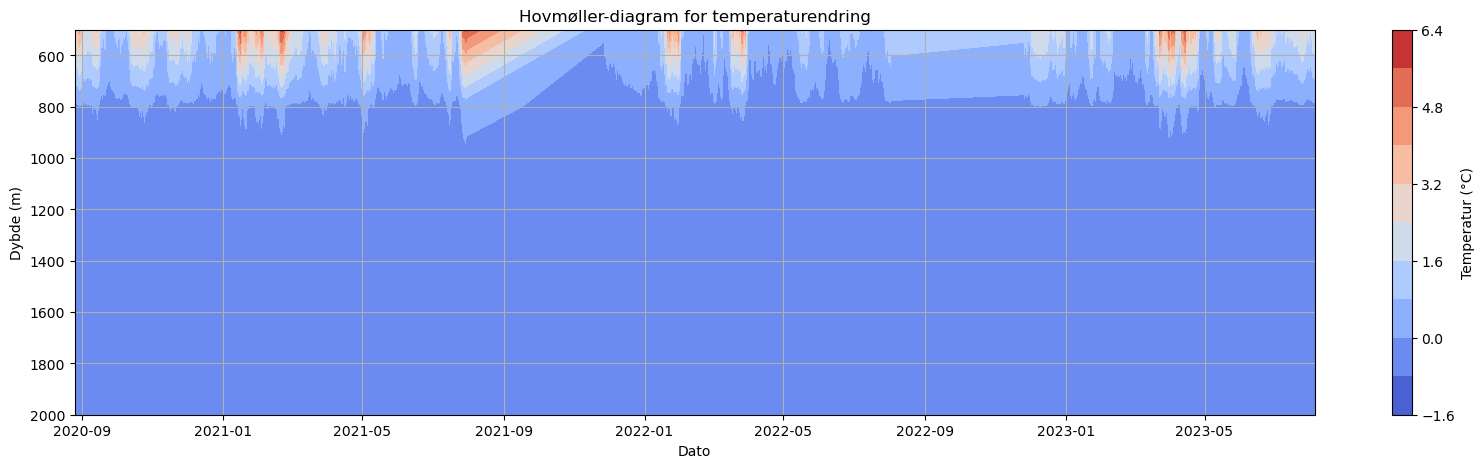

In [22]:
depth = np.array([500, 800, 1000, 1200, 2000])
time = all_500["TIME"]


temperature_data = {
    500: all_500["TEMP_FILTER"],   
    800: all_800["TEMP_FILTER"],   
    1000: all_1000["TEMP_FILTER"], 
    1200: all_1200["TEMP_FILTER"], 
    2000: all_2000["TEMP_FILTER"]}


X, Y = np.meshgrid(time,depth)
# Lager en temperatur-matrise for hver dybde. 
temperature_matrix = np.array([temperature_data[d] for d in depth])

plt.figure(figsize=(20, 5))
plt.contourf(X, Y, temperature_matrix, cmap='coolwarm', levels = 10)
plt.colorbar(label='Temperatur (°C)')
plt.xlabel('Dato')
plt.ylabel('Dybde (m)')
plt.title('Hovmøller-diagram for temperaturendring')
plt.gca().invert_yaxis()  # Inverter y-aksen for å vise dybde fra 500m til 2000m
plt.grid(True)


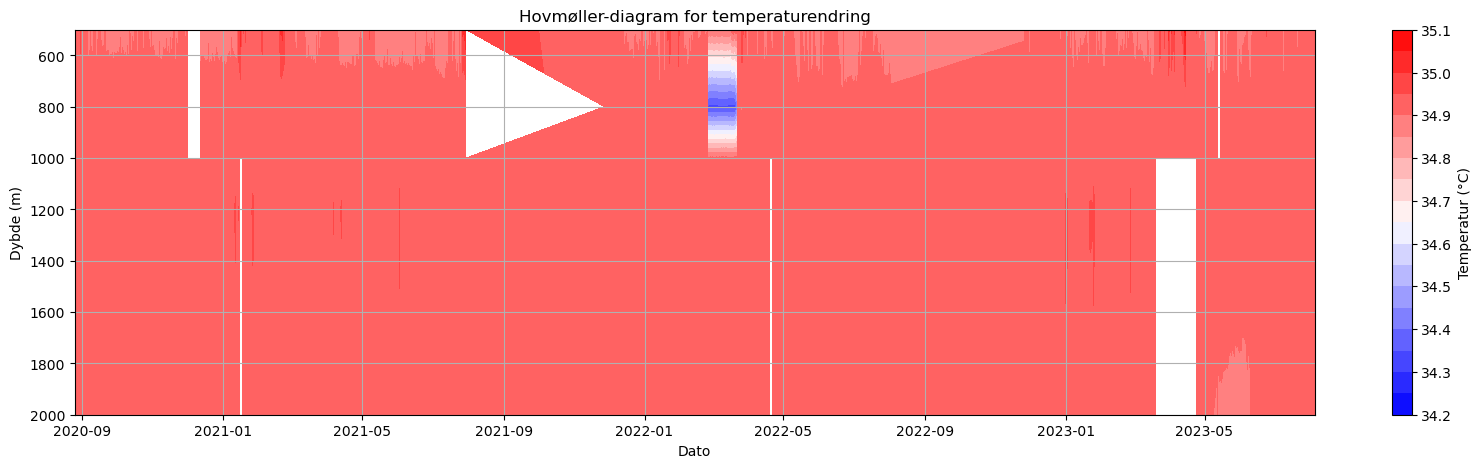

In [23]:
depth = np.array([500, 800, 1000, 1200, 2000])
time = all_500["TIME"]


temperature_data = {
    500: all_500["PSAL_FILTER"],   
    800: all_800["PSAL_FILTER"],   
    1000: all_1000["PSAL_FILTER"], 
    1200: all_1200["PSAL_FILTER"], 
    2000: all_2000["PSAL"] 
}


X, Y = np.meshgrid(time,depth)
# Lager en temperatur-matrise for hver dybde. 
temperature_matrix = np.array([temperature_data[d] for d in depth])

plt.figure(figsize=(20, 5))
plt.contourf(X, Y, temperature_matrix, cmap='bwr', levels=20)
plt.colorbar(label='Temperatur (°C)')
plt.xlabel('Dato')
plt.ylabel('Dybde (m)')
plt.title('Hovmøller-diagram for temperaturendring')
plt.gca().invert_yaxis()  # Inverter y-aksen for å vise dybde fra 500m til 2000m
plt.grid(True)


# Finne x,y koordinater til mooringene i modellene. 

In [24]:
def get_XYpositions(filename, lons, lats):
    # Open the dataset
    fh  = xr.open_dataset(filename)
    
    x   = np.linspace(0, fh.lat.values.shape[1]-1, fh.lat.values.shape[1])
    y   = np.linspace(0, fh.lat.values.shape[0]-1, fh.lat.values.shape[0])
    xi  = np.zeros_like(fh.lon.values)
    yi  = np.zeros([fh.lon.values.shape[1], fh.lon.values.shape[0]])
    xi[:,:] = x
    yi[:,:] = y
    yi  = np.swapaxes(yi, 1, 0)

    # First I define the wet points of the field as the lon,lat values with mask_rho==1 
    sea_def = pyresample.geometry.SwathDefinition(lons= fh.lon.values[np.where(fh.mask_rho)], lats = fh.lat.values[np.where(fh.mask_rho)])

    # Second, the full grid definiton (our target domain):
    orig_def = pyresample.geometry.SwathDefinition(lons=lons, lats=lats)

    # Then I fill the temperature field by the nearest neighbour approace.
    # Note that only wet points are used as input. 

    # The radius of influence sets a limit (in meters) for how far away a true value can be from the point that will be filled

    ypos = pyresample.kd_tree.resample_nearest(sea_def, yi[np.where(fh.mask_rho)], \
                               orig_def, radius_of_influence=2400)

    xpos = pyresample.kd_tree.resample_nearest(sea_def, xi[np.where(fh.mask_rho)], \
                               orig_def, radius_of_influence=2400)
    return np.array([int(x) for x in xpos]), np.array([int(y) for y in ypos])

In [25]:
target_depths = [300]
locations = {'SouthCape':  {'lat':76.107,    'lon': 15.967 }, 
             'MooringM_d1':{'lat':65.829002, 'lon': 2.203  },
             'MooringM_d2':{'lat':65.015,    'lon': 1.983  },
             'MooringM_d3':{'lat':66.0 ,     'lon': 1.99   }
            }
dtg = datetime.datetime.now() - datetime.timedelta(days =0 )

In [26]:
#path = '/lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/{}/{}/norshelf_qck_ZDEPTHS_an_{}T00Z.nc'
nordshelf_path = '/lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/2020/10/norshelf_qck_ZDEPTHS_an_20201001T00Z.nc'
nordshelf_ds   = xr.open_dataset(nordshelf_path.format(my_date.strftime('%Y%m%d')))

nordshelf_path2 = '/lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/2020/10/norshelf_qck_ZDEPTHS_an_20201002T00Z.nc'
nordshelf_ds2   = xr.open_dataset(nordshelf_path2.format(my_date.strftime('%Y%m%d')))
                                                                   
nordshelf_path3 =  '/lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/2020/10/norshelf_qck_ZDEPTHS_an_20201003T00Z.nc'                                    
nordshelf_ds3   = xr.open_dataset(nordshelf_path3.format(my_date.strftime('%Y%m%d')))
nordshelf_ds3

<xarray.Dataset>
Dimensions:       (s_rho: 42, eta_rho: 351, xi_rho: 901, time: 24, depth: 17)
Coordinates:
  * eta_rho       (eta_rho) int32 -1764800 -1762400 -1760000 ... -927200 -924800
    lat           (eta_rho, xi_rho) float64 ...
    lon           (eta_rho, xi_rho) float64 ...
  * time          (time) datetime64[ns] 2020-10-03 ... 2020-10-03T23:00:00
  * xi_rho        (xi_rho) int32 -3326400 -3324000 ... -1168800 -1166400
  * depth         (depth) float64 0.0 1.0 3.0 5.0 ... 150.0 200.0 250.0 300.0
Dimensions without coordinates: s_rho
Data variables:
    Cs_r          (s_rho) float64 ...
    grid_mapping  int32 ...
    h             (eta_rho, xi_rho) float64 ...
    hc            float64 ...
    mask_rho      (eta_rho, xi_rho) float64 ...
    salinity      (time, depth, eta_rho, xi_rho) float32 ...
    temperature   (time, depth, eta_rho, xi_rho) float32 ...
    u_eastward    (time, depth, eta_rho, xi_rho) float32 ...
    v_northward   (time, depth, eta_rho, xi_rho) float32 ...
    zeta          (time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    file:              /home/metno_op/run/norshelf/norshelf_his_20201003T00Z.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             MET NorShelf (2.4km)
    var_info:          /home/metno_op/run/norshelf/norshelf_varinfo.dat
    ...                ...
    compiler_flags:    -fp-model precise  -ip -O3
    tiling:            018x016
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       R4VAREPS, ADD_FSOBC, ADD_M2OBC, ALBEDO, ANA_BSFLUX, AN...
    NCO:               netCDF Operators version 5.1.0 (Homepage = http://nco....
    history:           Fri Dec  1 08:21:43 2023: /modules/rhel8/conda/install...

In [27]:
# Beregn X, Y posisjon for stasjoner i dictionary locations, sett opp et pandas dataframe for å lagre resultater i: 
for loc, coord in locations.items():
    df = pd.DataFrame({'SITE': [] , 'LAT': [], 'LONG': [], 'DEPTH': [], 'TIME': [] , 'PROG': [], 'CD[deg]': [], 'CV[m/s]': [] })

    locations[loc]['X'], locations[loc]['Y'] = get_XYpositions(nordshelf_path.format( dtg.strftime('%Y/%m'), dtg.strftime('%Y%m%d')), np.array([coord['lon']]), np.array([coord['lat']])) 

for loc, coord in locations.items():
    df = pd.DataFrame({'SITE': [] , 'LAT': [], 'LONG': [], 'DEPTH': [], 'TIME': [] , 'PROG': [], 'CD[deg]': [], 'CV[m/s]': [] })

    locations[loc]['X'], locations[loc]['Y'] = get_XYpositions(nordshelf_path2.format( dtg.strftime('%Y/%m'), dtg.strftime('%Y%m%d')), np.array([coord['lon']]), np.array([coord['lat']])) 
   

In [28]:
for loc, coord in locations.items():
    df = pd.DataFrame({'SITE': [] , 'LAT': [], 'LONG': [], 'DEPTH': [], 'TIME': [] , 'PROG': [], 'CD[deg]': [], 'CV[m/s]': [] })

    locations[loc]['X'], locations[loc]['Y'] = get_XYpositions(nordshelf_path3.format( dtg.strftime('%Y/%m'), dtg.strftime('%Y%m%d')), np.array([coord['lon']]), np.array([coord['lat']])) 
   

In [29]:
print(f"Model: Norkyst")
print("")
for loc, coord in locations.items():
    print(f"Stasjon: {loc}")
    print(f"Latitude: {coord['lat']}, Longitude: {coord['lon']}")
    print(f"X-posisjon: {coord['X']}, Y-posisjon: {coord['Y']}")
    print("")

Model: Norkyst

Stasjon: SouthCape
Latitude: 76.107, Longitude: 15.967
X-posisjon: [0], Y-posisjon: [0]

Stasjon: MooringM_d1
Latitude: 65.829002, Longitude: 2.203
X-posisjon: [400], Y-posisjon: [333]

Stasjon: MooringM_d2
Latitude: 65.015, Longitude: 1.983
X-posisjon: [364], Y-posisjon: [323]

Stasjon: MooringM_d3
Latitude: 66.0, Longitude: 1.99
X-posisjon: [406], Y-posisjon: [340]



In [30]:
def extract_period_data(data, start_date, end_date):
    data['TIME'] = pd.to_datetime(data['TIME'])  # Konverter datoene til datetime-format
    period_data = data[(data['TIME'] >= start_date) & (data['TIME'] <= end_date)]  # Velg bare data for perioden mellom startdato og sluttdato
    return period_data

In [31]:
start_date = '2020-10-01 00:00:00'
end_date   = '2020-10-03 23:00:56.249999872'
period_data = extract_period_data(d1_500m, start_date, end_date)  # Bruk funksjonen for å hente ut data for perioden mellom start- og sluttdatoene
period_data

/tmp/ipykernel_4183998/3473519449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TIME'] = pd.to_datetime(data['TIME'])  # Konverter datoene til datetime-format


,DEPTH,TIME,TEMP,TEMP_QC,PSAL,PSAL_QC,LATITUDE,LONGITUDE,PSAL_FILTER,TEMP_FILTER
876,500.0,2020-10-01 00:00:00.000000000,0.8055,1.0,34.887409,1.0,65.829002,2.203,34.887409,0.8055
877,500.0,2020-10-01 00:59:03.750000128,0.8870,1.0,34.891010,1.0,65.829002,2.203,34.891010,0.8870
878,500.0,2020-10-01 02:00:56.249999872,0.9113,1.0,34.890110,1.0,65.829002,2.203,34.890110,0.9113
879,500.0,2020-10-01 03:00:00.000000000,0.9200,1.0,34.892410,1.0,65.829002,2.203,34.892410,0.9200
880,500.0,2020-10-01 03:59:03.750000128,0.9521,1.0,34.887611,1.0,65.829002,2.203,34.887611,0.9521
...,...,...,...,...,...,...,...,...,...,...
943,500.0,2020-10-03 18:59:03.750000128,1.0817,1.0,34.889809,1.0,65.829002,2.203,34.889809,1.0817
944,500.0,2020-10-03 20:00:56.249999872,0.9437,1.0,34.887508,1.0,65.829002,2.203,34.887508,0.9437
945,500.0,2020-10-03 21:00:00.000000000,0.9026,1.0,34.891609,1.0,65.829002,2.203,34.891609,0.9026
946,500.0,2020-10-03 21:59:03.750000128,1.0286,1.0,34.877010,1.0,65.829002,2.203,34.877010,1.0286


In [32]:
print(nordshelf_ds.dims)
print(nordshelf_ds2.dims)
print(nordshelf_ds3.dims)

Frozen({'s_rho': 42, 'eta_rho': 351, 'xi_rho': 901, 'time': 24, 'depth': 17})
Frozen({'s_rho': 42, 'eta_rho': 351, 'xi_rho': 901, 'time': 24, 'depth': 17})
Frozen({'s_rho': 42, 'eta_rho': 351, 'xi_rho': 901, 'time': 24, 'depth': 17})


In [33]:
combined_data = xr.concat([nordshelf_ds, nordshelf_ds2, nordshelf_ds3], dim = "time")

In [34]:
len(combined_data["temperature"])

72

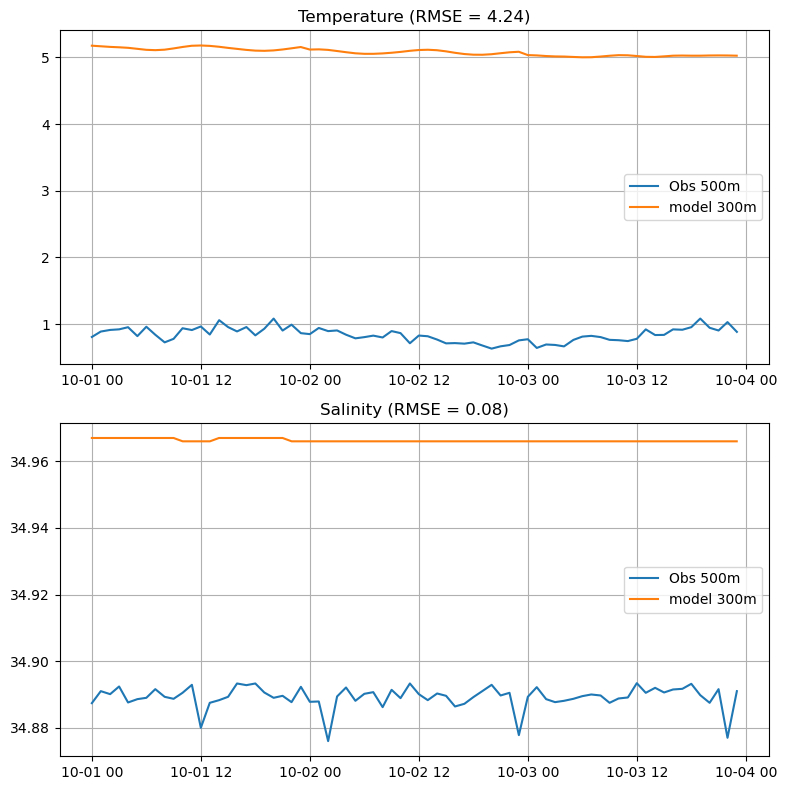

In [35]:
#RMSE_temp = np.sqrt(np.mean((period_data["TEMP_FILTER"][0:-1]- nordshelf_ds["temperature"][:,-1, 333,400])**2))

RMSE_temp = np.sqrt(np.mean((period_data["TEMP_FILTER"].iloc[0:-1] - combined_data["temperature"][:len(period_data)-1,-1, 333,400])**2))
RMSE_sal  = np.sqrt(np.mean((period_data["PSAL_FILTER"].iloc[0:-1] - combined_data["salinity"][:len(period_data)-1,-1, 333,400])**2))
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot 1: Temperatur
axs[0].plot(period_data["TIME"], period_data["TEMP_FILTER"], label="Obs 500m")
axs[0].plot(combined_data["time"], combined_data["temperature"][:,-1, 333,400], label="model 300m")
axs[0].set_title(f"Temperature (RMSE = {RMSE_temp:.2f})")
axs[0].legend()
axs[0].grid()

# Plot 2: Salinity
axs[1].plot(period_data["TIME"], period_data["PSAL_FILTER"], label="Obs 500m")
axs[1].plot(combined_data["time"], combined_data["salinity"][:,-1, 333,400], label="model 300m")
axs[1].set_title(f"Salinity (RMSE = {RMSE_sal:.2f})")
axs[1].legend()
axs[1].grid()

plt.tight_layout()


In [36]:
path = ""